<ul>
<li> Original Data: F
<li> Data after Difference: F_diff_1
<li> Data after Minmax: F_scaled
    </ul>

Function:
<ul>
<li>max_mi: Return each X with lag K that has the Maximum Mutual Information with Y</li>
<li>max_mic: Return each X with lag K that has the Maximum Information Coefficient with Y</li>
<li>max_pcorr_dict: Return each X with lag K that has the maximum Partial Correlation with Y </li>
 </ul>

In [19]:
import pandas as pd
import numpy as np
import numpy.random as nr
import pandas_datareader.data as web
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
from scipy import stats
import scipy.spatial as ss
from scipy.special import digamma
import numpy.random as nr
import random
import matplotlib.pyplot as plt
import re
from scipy.stats.stats import pearsonr
import numpy.linalg as la
from numpy.linalg import eig, inv, norm, det
from scipy import stats
from math import log,pi,hypot,fabs,sqrt
from sklearn.neighbors import KDTree, NearestNeighbors
from sklearn.feature_selection import SelectKBest
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

### Split Data into Lagged Feature DataFrame

In [3]:
def split_features(data):
    high_df = pd.concat([data.iloc[:,:31],data['Close_1']],axis=1)
    open_df = pd.concat([data.iloc[:,31:62],data['Close_1']],axis=1)
    low_df = pd.concat([data.iloc[:,62:93],data['Close_1']],axis=1)
    vol_df = pd.concat([data.iloc[:,93:-1],data['Close_1']],axis=1)
    df_all = [high_df,open_df,low_df,vol_df]
    return df_all

#### Original Data

In [4]:
start_day = datetime.datetime(2002,6,13)
end_day = datetime.datetime(2022,6,13)
dj1 = web.get_data_stooq('^DJI',start_day,end_day)
dj1.sort_index(ascending=True,inplace=True)
dj1['Close_1'] = dj1['Close'].shift(-1)

d = range(0,31)
high_lag = pd.DataFrame(dj1['High'])
for i in d[1:]:
    column = 'high_lag_'+str(i)
    high_lag[column] = dj1['High'].shift(i)
    
open_lag = pd.DataFrame(dj1['Open'])
for i in d[1:]:
    column = 'open_lag_'+str(i)
    open_lag[column] = dj1['Open'].shift(i)
    
low_lag = pd.DataFrame(dj1['Low'])
for i in d[1:]:
    column = 'low_lag_'+str(i)
    low_lag[column] = dj1['Low'].shift(i)
    
vol_lag = pd.DataFrame(dj1['Volume'])
for i in range(1,31):
    column = 'vol_lag_'+str(i)
    vol_lag[column] = dj1['Volume'].shift(i)
F = pd.concat([high_lag,open_lag,low_lag,vol_lag,dj1['Close_1']],axis=1)

In [5]:
features_original = split_features(F.iloc[30:-1,:])

In [37]:
high_df = features_original[0]

In [43]:
X = high_df.iloc[:,1]
Y = high_df.iloc[:,-1]

### 1.1 Compute Metrics

In [327]:
for df in features_original:
    mi_features_names.append(max_mi(df.iloc[:,:-1],df.iloc[:,-1])[1])
    max_mic(df.iloc[:,:-1],df.iloc[:,-1])[1]
    print("Max Partial Correlation:",max_pcorr_dict(df,df.iloc[:,:-1],df.columns[-1]))

Mutual Information:  (array([3.45707418]), 'High')
Maximum Information Coefficient:  (0.9999999712037217, 'high_lag_1')
Max Partial Correlation: (0.9995477543139842, 'High')
Mutual Information:  (array([3.27942934]), 'Open')
Maximum Information Coefficient:  (0.9999999712037217, 'open_lag_1')
Max Partial Correlation: (0.9994524967112324, 'Open')
Mutual Information:  (array([3.44744146]), 'Low')
Maximum Information Coefficient:  (0.9999999712037217, 'low_lag_2')
Max Partial Correlation: (0.9995623962098137, 'Low')
Mutual Information:  (array([0.68207386]), 'vol_lag_5')
Maximum Information Coefficient:  (0.5105186476099398, 'vol_lag_2')
Max Partial Correlation: (0.41274831753867214, 'Volume')


### Generate feature names

In [6]:
def generate_features_names(features_df,data):
    mi_feature_names = [max_mi(df.iloc[:,:-1],df.iloc[:,-1])[1] for df in features_df]
    mi_df = data[ mi_feature_names + [data.columns[-1]] ]
    mic_feature_names = [max_mic(df.iloc[:,:-1],df.iloc[:,-1])[1] for df in features_df ]
    mic_df = data[ mic_feature_names + [data.columns[-1]] ] 
    pcorr_feature_names = [max_pcorr_dict(df,df.iloc[:,:-1],df.columns[-1])[1] for df in features_df ]
    pcorr_df = data[pcorr_feature_names  + [data.columns[-1]] ]
    return mi_df ,mic_df,pcorr_df

In [12]:
mi_df,mic_df,pcorr_df = generate_features_names(features_original,F.iloc[30:-1,:])

Mutual Information:  (array([3.45699285]), 'High')
Mutual Information:  (array([3.27941238]), 'Open')
Mutual Information:  (array([3.44731313]), 'Low')
Mutual Information:  (array([0.68206433]), 'vol_lag_5')
Maximum Information Coefficient:  (0.9999999712037217, 'high_lag_1')
Maximum Information Coefficient:  (0.9999999712037217, 'open_lag_1')
Maximum Information Coefficient:  (0.9999999712037217, 'low_lag_2')
Maximum Information Coefficient:  (0.5105186476099398, 'vol_lag_2')
Max Partial Correlation: (0.9995477543139842, 'High')
Max Partial Correlation: (0.9994524967112324, 'Open')
Max Partial Correlation: (0.9995623962098137, 'Low')
Max Partial Correlation: (0.41274831753867214, 'Volume')


### SVR Model

#### mi

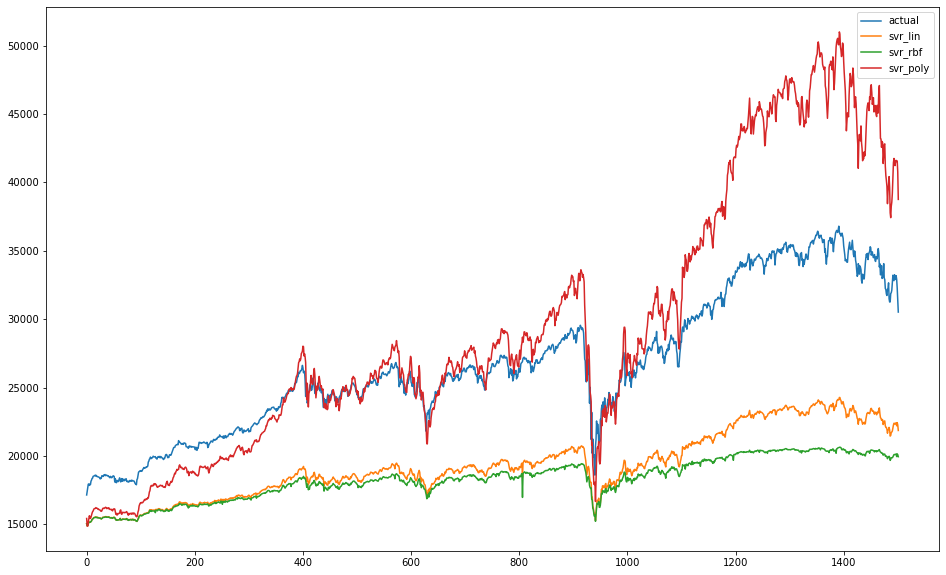

In [17]:
mi_original = mi_df.values
X_mi = mi_original[:,:-1]
Y_mi = mi_original[:,-1].reshape((-1,1))
sc_x = MinMaxScaler(feature_range=(0,1))
sc_y = MinMaxScaler(feature_range=(0,1))
xx = sc_x.fit_transform(X_mi)
yy = sc_y.fit_transform(Y_mi)


def split_data(X,Y,percent):
    test_len = int(len(X) * percent)
    X_train = X[:test_len]
    X_test = X[test_len:]
    Y_train = Y[:test_len]
    Y_test = Y[test_len:]
    return X_train,X_test,Y_train,Y_test

X_train,X_test,Y_train,Y_test = split_data(xx,yy,0.7)

svr_lin  = SVR(kernel='linear', C=100)
svr_poly = SVR(kernel='poly', C=10, degree=2)
svr_rbf = SVR(kernel='rbf', C=100, gamma=0.2)
svr_lin .fit(X_train,Y_train.reshape((-1,)))
svr_poly.fit(X_train,Y_train.reshape((-1,)))
svr_rbf.fit(X_train,Y_train.reshape((-1,)))

y_lin = sc_y.inverse_transform(svr_lin.predict(X_test).reshape((-1,1)))
y_rbf = sc_y.inverse_transform(svr_rbf.predict(X_test).reshape((-1,1)))
y_poly = sc_y.inverse_transform(svr_poly.predict(X_test).reshape((-1,1)))
actual = sc_y.inverse_transform(Y_test)

plt.figure(figsize = (16,10))
plt.plot(actual,label="actual")
plt.plot(y_lin,label='svr_lin')
plt.plot(y_rbf,label='svr_rbf')
plt.plot(y_poly,label='svr_poly')
plt.legend()

In [20]:
print("r2 score:", r2_score(actual,y_poly))

r2 score: -0.1328543058509224


### mic

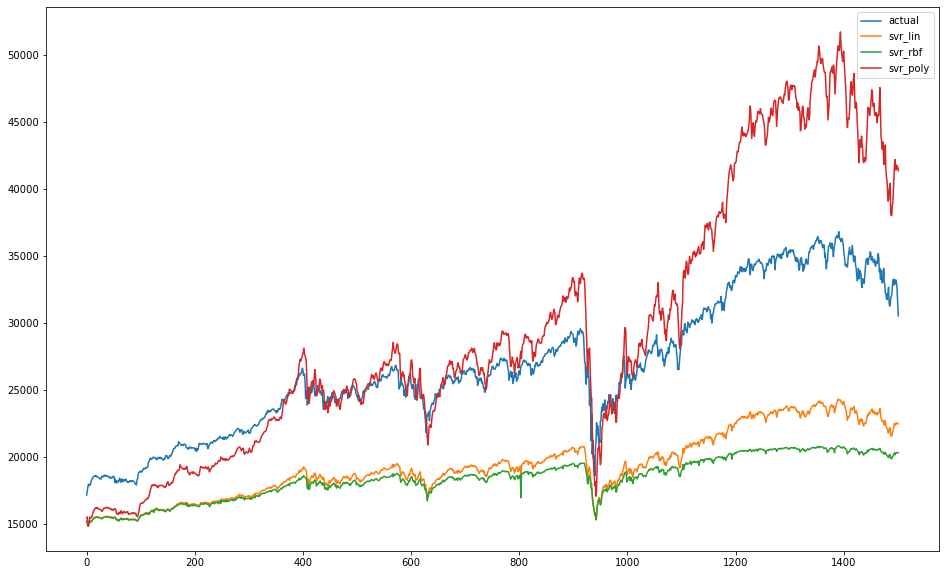

In [21]:
mic_original = mic_df.values
X_mi = mic_original[:,:-1]
Y_mi = mic_original[:,-1].reshape((-1,1))
sc_x = MinMaxScaler(feature_range=(0,1))
sc_y = MinMaxScaler(feature_range=(0,1))
xx = sc_x.fit_transform(X_mi)
yy = sc_y.fit_transform(Y_mi)

X_train,X_test,Y_train,Y_test = split_data(xx,yy,0.7)

svr_lin  = SVR(kernel='linear', C=100)
svr_poly = SVR(kernel='poly', C=10, degree=2)
svr_rbf = SVR(kernel='rbf', C=100, gamma=0.2)
svr_lin .fit(X_train,Y_train.reshape((-1,)))
svr_poly.fit(X_train,Y_train.reshape((-1,)))
svr_rbf.fit(X_train,Y_train.reshape((-1,)))

y_lin = sc_y.inverse_transform(svr_lin.predict(X_test).reshape((-1,1)))
y_rbf = sc_y.inverse_transform(svr_rbf.predict(X_test).reshape((-1,1)))
y_poly = sc_y.inverse_transform(svr_poly.predict(X_test).reshape((-1,1)))
actual = sc_y.inverse_transform(Y_test)

plt.figure(figsize = (16,10))
plt.plot(actual,label="actual")
plt.plot(y_lin,label='svr_lin')
plt.plot(y_rbf,label='svr_rbf')
plt.plot(y_poly,label='svr_poly')
plt.legend()

In [22]:
print("r2 score:", r2_score(actual,y_poly))

r2 score: -0.1855141405493439


### pcorr

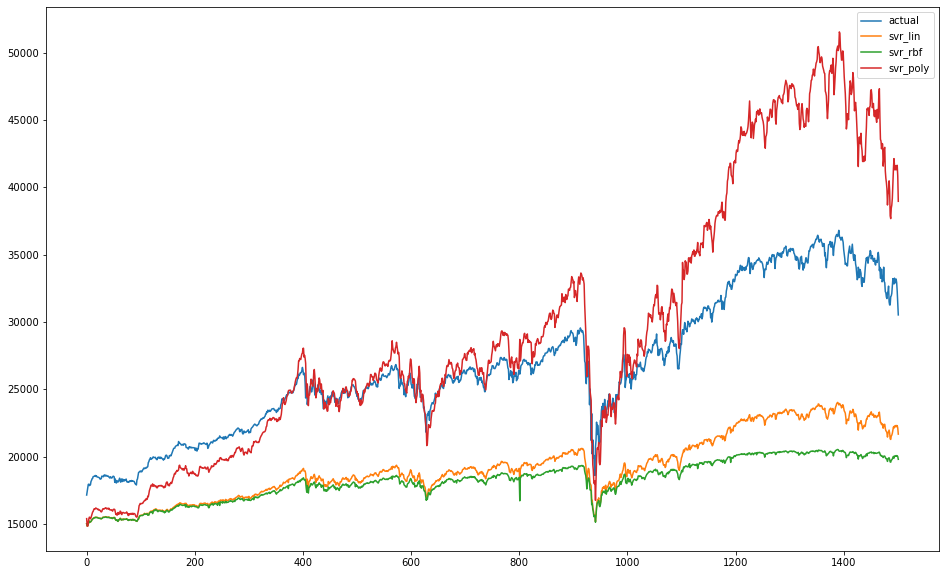

In [23]:
pcorr_original = pcorr_df.values
X_mi = pcorr_original[:,:-1]
Y_mi = pcorr_original[:,-1].reshape((-1,1))
sc_x = MinMaxScaler(feature_range=(0,1))
sc_y = MinMaxScaler(feature_range=(0,1))
xx = sc_x.fit_transform(X_mi)
yy = sc_y.fit_transform(Y_mi)

X_train,X_test,Y_train,Y_test = split_data(xx,yy,0.7)

svr_lin  = SVR(kernel='linear', C=100)
svr_poly = SVR(kernel='poly', C=10, degree=2)
svr_rbf = SVR(kernel='rbf', C=100, gamma=0.2)
svr_lin .fit(X_train,Y_train.reshape((-1,)))
svr_poly.fit(X_train,Y_train.reshape((-1,)))
svr_rbf.fit(X_train,Y_train.reshape((-1,)))

y_lin = sc_y.inverse_transform(svr_lin.predict(X_test).reshape((-1,1)))
y_rbf = sc_y.inverse_transform(svr_rbf.predict(X_test).reshape((-1,1)))
y_poly = sc_y.inverse_transform(svr_poly.predict(X_test).reshape((-1,1)))
actual = sc_y.inverse_transform(Y_test)

plt.figure(figsize = (16,10))
plt.plot(actual,label="actual")
plt.plot(y_lin,label='svr_lin')
plt.plot(y_rbf,label='svr_rbf')
plt.plot(y_poly,label='svr_poly')
plt.legend()

In [24]:
print("r2 score:", r2_score(actual,y_poly))

r2 score: -0.16199536223121846


### SelectKBest+MI

In [369]:
# feature selection
def select_features(X_train, y_train, X_test):
    # configure to select a subset of features
    fs = SelectKBest(score_func=mutual_info_regression, k=10)
    # learn relationship from training data
    fs.fit(X_train, y_train)
    # transform train input data
    X_train_fs = fs.transform(X_train)
    # transform test input data
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

In [348]:
test_df = F.iloc[30:-1,:]

In [350]:
test_len = int(len(test_df)*0.7)

X_train = test_df.iloc[:test_len,:-1]
X_test = test_df.iloc[test_len:,:-1]
y_train = test_df.iloc[:test_len,-1]
y_test = test_df.iloc[test_len:,-1]

In [370]:
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)

In [371]:
mask = fs.get_support()
X_test.columns[mask]

Index(['High', 'high_lag_1', 'high_lag_2', 'high_lag_3', 'Open', 'open_lag_1',
       'open_lag_2', 'Low', 'low_lag_1', 'low_lag_2'],
      dtype='object')

#### Minmax Scaled Data

In [333]:
features = F.iloc[30:-1,:-1].copy()
target = F.iloc[30:-1,-1].copy()
# F_scaled = F.iloc[30:-1,:].copy()

X = np.array(features)
Y = np.array(target).reshape((-1,1))
SC_X = MinMaxScaler(feature_range=(0,1))
SC_Y = MinMaxScaler(feature_range=(0,1))
x_mic = SC_X.fit_transform(X)
y_mic = SC_Y.fit_transform(Y)

for i in range(F_scaled.shape[1]):
    if i< F_scaled.shape[1] - 1:
        F_scaled.iloc[:,i] = x_mic[:,i]
    F_scaled.iloc[:,i] = y_mic.reshape((-1,))

In [334]:
features_minmax = split_features(F_scaled)

### 2.1 Compute Metrics

In [344]:
for df in features_minmax:
    max_mi(df.iloc[:,:-1],df.iloc[:,-1])
    max_mic(df.iloc[:,:-1],df.iloc[:,-1])
    print("Max Partial Correlation:",max_pcorr_dict(df,df.iloc[:,:-1],df.columns[-1]))

Mutual Information:  (array([7.25852857]), 'high_lag_18')
Maximum Information Coefficient:  (1.0000000000000007, 'high_lag_9')
Max Partial Correlation: (-inf, 'high_lag_9')


C:\Users\rich\anaconda3\lib\site-packages\pingouin\correlation.py:59: RuntimeWarning: invalid value encountered in double_scalars
  tval = r * np.sqrt(dof / (1 - r**2))
C:\Users\rich\anaconda3\lib\site-packages\pingouin\effsize.py:157: RuntimeWarning: invalid value encountered in arctanh
  z = np.arctanh(stat)  # R-to-z transform


Mutual Information:  (array([7.25917792]), 'open_lag_22')
Maximum Information Coefficient:  (1.0000000000000007, 'open_lag_9')
Max Partial Correlation: (-inf, 'open_lag_9')


C:\Users\rich\anaconda3\lib\site-packages\pingouin\correlation.py:59: RuntimeWarning: invalid value encountered in double_scalars
  tval = r * np.sqrt(dof / (1 - r**2))
C:\Users\rich\anaconda3\lib\site-packages\pingouin\effsize.py:157: RuntimeWarning: invalid value encountered in arctanh
  z = np.arctanh(stat)  # R-to-z transform


Mutual Information:  (array([7.25864512]), 'low_lag_18')
Maximum Information Coefficient:  (1.0000000000000007, 'low_lag_9')
Max Partial Correlation: (-inf, 'low_lag_9')


C:\Users\rich\anaconda3\lib\site-packages\pingouin\correlation.py:59: RuntimeWarning: invalid value encountered in double_scalars
  tval = r * np.sqrt(dof / (1 - r**2))
C:\Users\rich\anaconda3\lib\site-packages\pingouin\effsize.py:157: RuntimeWarning: invalid value encountered in arctanh
  z = np.arctanh(stat)  # R-to-z transform


Mutual Information:  (array([7.25861182]), 'vol_lag_1')
Maximum Information Coefficient:  (1.0000000000000007, 'vol_lag_9')
Max Partial Correlation: (-inf, 'vol_lag_9')


C:\Users\rich\anaconda3\lib\site-packages\pingouin\correlation.py:59: RuntimeWarning: invalid value encountered in double_scalars
  tval = r * np.sqrt(dof / (1 - r**2))
C:\Users\rich\anaconda3\lib\site-packages\pingouin\effsize.py:157: RuntimeWarning: invalid value encountered in arctanh
  z = np.arctanh(stat)  # R-to-z transform


#### Differenced Data

In [25]:
F_diff_1 = F.diff(1).dropna()
features_diff_1 = split_features(F_diff_1)

### 3.1 Compute Metrics

In [340]:
for df in features_diff_1:
    max_mi(df.iloc[:,:-1],df.iloc[:,-1])
    max_mic(df.iloc[:,:-1],df.iloc[:,-1])
    print("Max Partial Correlation:",max_pcorr_dict(df,df.iloc[:,:-1],df.columns[-1]))

Mutual Information:  (array([0.06217591]), 'high_lag_2')
Maximum Information Coefficient:  (0.08377267492468345, 'high_lag_28')
Max Partial Correlation: (0.07704396089130817, 'high_lag_1')
Mutual Information:  (array([0.068026]), 'Open')
Maximum Information Coefficient:  (0.08340247253604348, 'open_lag_28')
Max Partial Correlation: (0.06231115151704472, 'open_lag_1')
Mutual Information:  (array([0.07198743]), 'low_lag_1')
Maximum Information Coefficient:  (0.08654140997266575, 'low_lag_3')
Max Partial Correlation: (0.07789350296235374, 'low_lag_1')
Mutual Information:  (array([0.02372385]), 'vol_lag_3')
Maximum Information Coefficient:  (0.08669077737836842, 'vol_lag_11')
Max Partial Correlation: (0.03685452889848453, 'vol_lag_23')


In [26]:
mi_diff_df,mic_diff_df,pcorr_diff_df = generate_features_names(features_diff_1,F_diff_1)

Mutual Information:  (array([0.06212153]), 'high_lag_2')
Mutual Information:  (array([0.06800138]), 'Open')
Mutual Information:  (array([0.07202843]), 'low_lag_1')
Mutual Information:  (array([0.02377126]), 'vol_lag_3')
Maximum Information Coefficient:  (0.08377267492468345, 'high_lag_28')
Maximum Information Coefficient:  (0.08340247253604348, 'open_lag_28')
Maximum Information Coefficient:  (0.08654140997266575, 'low_lag_3')
Maximum Information Coefficient:  (0.08669077737836842, 'vol_lag_11')
Max Partial Correlation: (0.07704396089130817, 'high_lag_1')
Max Partial Correlation: (0.06231115151704472, 'open_lag_1')
Max Partial Correlation: (0.07789350296235374, 'low_lag_1')
Max Partial Correlation: (0.03685452889848453, 'vol_lag_23')


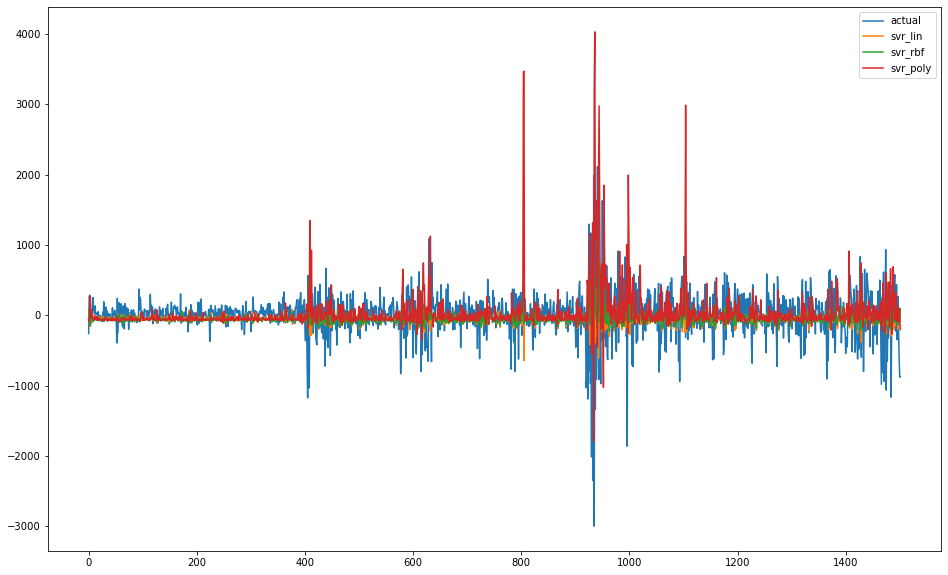

In [27]:
mi_diff = mi_diff_df.values
X_mi = mi_diff[:,:-1]
Y_mi = mi_diff[:,-1].reshape((-1,1))
sc_x = MinMaxScaler(feature_range=(0,1))
sc_y = MinMaxScaler(feature_range=(0,1))
xx = sc_x.fit_transform(X_mi)
yy = sc_y.fit_transform(Y_mi)

X_train,X_test,Y_train,Y_test = split_data(xx,yy,0.7)

svr_lin  = SVR(kernel='linear', C=100)
svr_poly = SVR(kernel='poly', C=10, degree=2)
svr_rbf = SVR(kernel='rbf', C=100, gamma=0.2)
svr_lin .fit(X_train,Y_train.reshape((-1,)))
svr_poly.fit(X_train,Y_train.reshape((-1,)))
svr_rbf.fit(X_train,Y_train.reshape((-1,)))

y_lin = sc_y.inverse_transform(svr_lin.predict(X_test).reshape((-1,1)))
y_rbf = sc_y.inverse_transform(svr_rbf.predict(X_test).reshape((-1,1)))
y_poly = sc_y.inverse_transform(svr_poly.predict(X_test).reshape((-1,1)))
actual = sc_y.inverse_transform(Y_test)

plt.figure(figsize = (16,10))
plt.plot(actual,label="actual")
plt.plot(y_lin,label='svr_lin')
plt.plot(y_rbf,label='svr_rbf')
plt.plot(y_poly,label='svr_poly')
plt.legend()

In [28]:
print("lin r2 score:", r2_score(actual,y_lin))
print("rbf r2 score:", r2_score(actual,y_rbf))
print("poly r2 score:", r2_score(actual,y_poly))

lin r2 score: -0.14402508506768497
rbf r2 score: -0.15623948242544627
poly r2 score: -1.060162196723914


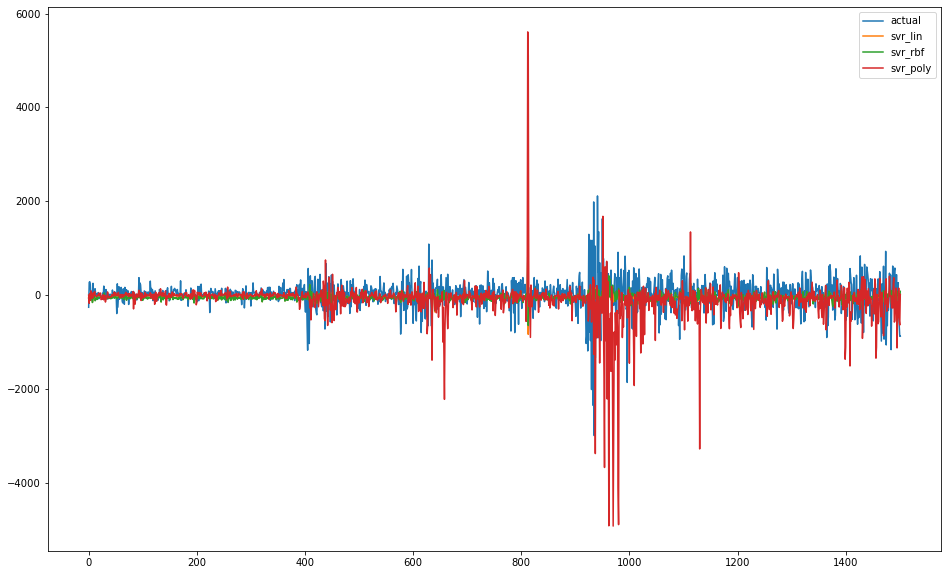

In [29]:
mic_diff = mic_diff_df.values
X_mi = mic_diff[:,:-1]
Y_mi = mic_diff[:,-1].reshape((-1,1))
sc_x = MinMaxScaler(feature_range=(0,1))
sc_y = MinMaxScaler(feature_range=(0,1))
xx = sc_x.fit_transform(X_mi)
yy = sc_y.fit_transform(Y_mi)

X_train,X_test,Y_train,Y_test = split_data(xx,yy,0.7)

svr_lin  = SVR(kernel='linear', C=100)
svr_poly = SVR(kernel='poly', C=10, degree=2)
svr_rbf = SVR(kernel='rbf', C=100, gamma=0.2)
svr_lin .fit(X_train,Y_train.reshape((-1,)))
svr_poly.fit(X_train,Y_train.reshape((-1,)))
svr_rbf.fit(X_train,Y_train.reshape((-1,)))

y_lin = sc_y.inverse_transform(svr_lin.predict(X_test).reshape((-1,1)))
y_rbf = sc_y.inverse_transform(svr_rbf.predict(X_test).reshape((-1,1)))
y_poly = sc_y.inverse_transform(svr_poly.predict(X_test).reshape((-1,1)))
actual = sc_y.inverse_transform(Y_test)

plt.figure(figsize = (16,10))
plt.plot(actual,label="actual")
plt.plot(y_lin,label='svr_lin')
plt.plot(y_rbf,label='svr_rbf')
plt.plot(y_poly,label='svr_poly')
plt.legend()

In [30]:
print("lin r2 score:", r2_score(actual,y_lin))
print("rbf r2 score:", r2_score(actual,y_rbf))
print("poly r2 score:", r2_score(actual,y_poly))

lin r2 score: -0.06697076519493028
rbf r2 score: -0.07829674003284093
poly r2 score: -2.155156524263056


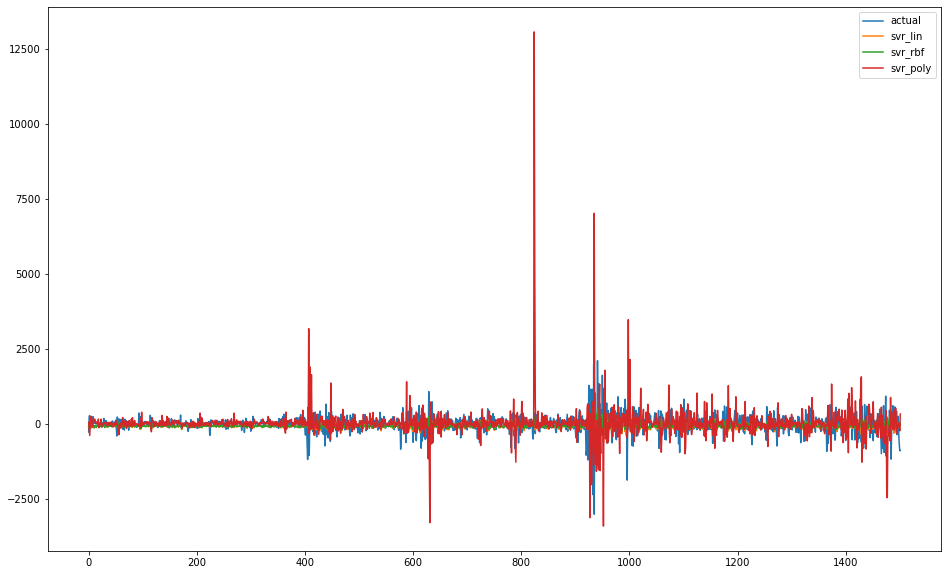

In [31]:
pcorr_diff = pcorr_diff_df.values
X_mi = pcorr_diff[:,:-1]
Y_mi = pcorr_diff[:,-1].reshape((-1,1))
sc_x = MinMaxScaler(feature_range=(0,1))
sc_y = MinMaxScaler(feature_range=(0,1))
xx = sc_x.fit_transform(X_mi)
yy = sc_y.fit_transform(Y_mi)



X_train,X_test,Y_train,Y_test = split_data(xx,yy,0.7)

svr_lin  = SVR(kernel='linear', C=100)
svr_poly = SVR(kernel='poly', C=10, degree=2)
svr_rbf = SVR(kernel='rbf', C=100, gamma=0.2)
svr_lin .fit(X_train,Y_train.reshape((-1,)))
svr_poly.fit(X_train,Y_train.reshape((-1,)))
svr_rbf.fit(X_train,Y_train.reshape((-1,)))

y_lin = sc_y.inverse_transform(svr_lin.predict(X_test).reshape((-1,1)))
y_rbf = sc_y.inverse_transform(svr_rbf.predict(X_test).reshape((-1,1)))
y_poly = sc_y.inverse_transform(svr_poly.predict(X_test).reshape((-1,1)))
actual = sc_y.inverse_transform(Y_test)

plt.figure(figsize = (16,10))
plt.plot(actual,label="actual")
plt.plot(y_lin,label='svr_lin')
plt.plot(y_rbf,label='svr_rbf')
plt.plot(y_poly,label='svr_poly')
plt.legend()

In [32]:
print("lin r2 score:", r2_score(actual,y_lin))
print("rbf r2 score:", r2_score(actual,y_rbf))
print("poly r2 score:", r2_score(actual,y_poly))

lin r2 score: -0.17168625742851673
rbf r2 score: -0.1724744152646418
poly r2 score: -3.2985054568982974


### Mutual Information Function

In [425]:
# calculate <nx> of each feature
def avgdigamma(points,dvec):
#This part finds number of neighbors in some radius in the marginal space
#returns expectation value of <psi(nx)>
    N = len(points)
    tree = ss.cKDTree(points)
    avg = 0.
    for i in range(N):
        dist = dvec[i]
        #subtlety, we don't include the boundary point, 
        #but we are implicitly adding 1 to kraskov def bc center point is included
        num_points = len(tree.query_ball_point(points[i],dist-1e-15,p=float('inf'))) 
        avg += digamma(num_points)/N
    return avg

def mi_Kraskov(features,target, k=3,intens = 1e-10):
    #Merge features and the target into a single dataframe
#     X_x = features
#     Y_y = target
    X = np.vstack((features.T,target.T))
    
    # adding small noise to X, e.g., x<-X+noise
    x = []
    for i in range(len(X)):
        tem = []
        for j in range(len(X[i])):
            #every element becomes list
            #tem = [ [[ X[i][j]+ + intens*nr.rand(1)[0] ],[]...[]] , [[]...[]] , ... , [[]...[]] ]
            tem.append([X[i][j] + intens*nr.rand(1)[0]])
        x.append(tem)
    #Generate tree which amount is equal to the number of features
    points = []
    for j in range(len(x[0])):
        tem = []
        for i in range(len(x)):
            tem.append(x[i][j][0])
        points.append(tem)
    tree = ss.cKDTree(np.array(points))
    
    # every element stores the distance between points
    dvec = []
    for i in range(len(x)):
        dvec.append([])
        
    for point in points:
        # Find k-nearest neighbors in joint space, p=inf means max norm
        knn = tree.query(point, k+1, p=float('inf'))
        points_knn = []
        for i in range(len(x)):
            dvec[i].append(float('-inf'))
            points_knn.append([])
        for j in range(k+1):
            for i in range(len(x)):
                points_knn[i].append(points[knn[1][j]][i])

        # Find distances to k-nearest neighbors in each marginal space
        for i in range(k+1):
                for j in range(len(x)):
                    if dvec[j][-1] < fabs(points_knn[j][i]-points_knn[j][0]):
                        dvec[j][-1] = fabs(points_knn[j][i]-points_knn[j][0])

    ret = 0.
    for i in range(len(x)):
        ret -= avgdigamma(x[i], dvec[i])
    ret += digamma(k) - (float(len(x))-1.)/float(k) + (float(len(x))-1.) * digamma(len(x[0]))
    return ret

In [439]:
def multi_mi_cc(X, y, n_neighbors=4):
    """Compute mutual information between many to one continuous variable.
    Parameters
    ----------
    x : ndarray, shape (n_samples, n_features)
        Samples of continous features.
    y : ndarray, shape (n_samples, )
        Samples of continuous target variable     
    n_neighbors : int
        Number of nearest neighbors to search for each point, see [1]_.
    Returns
    -------
    mi : float
        Estimated mutual information. If it turned out to be negative it is
        replace by 0.
    Notes
    -----
    Adapted from sklearn.feature_selection._mutual_info._compute_mi_cc

    References
    ----------
    .. [1] A. Kraskov, H. Stogbauer and P. Grassberger, "Estimating mutual
           information". Phys. Rev. E 69, 2004.
    """
    n_samples = X.size

    if len(X.shape) == 1:
        X = X.reshape(-1, 1)
    y = y.reshape((-1, 1))
    xy = np.vstack((X, y))

    # Here we rely on NearestNeighbors to select the fastest algorithm.
    nn = NearestNeighbors(metric="chebyshev", n_neighbors=n_neighbors)

    nn.fit(xy)
    radius = nn.kneighbors()[0]
    radius = np.nextafter(radius[:, -1], 0)

    # KDTree is explicitly fit to allow for the querying of number of
    # neighbors within a specified radius
    nX = np.zeros_like(X)
    for i, x in enumerate(X):
        kd = KDTree(x.reshape(-1, 1))
        nx = kd.query_radius(x.reshape(-1, 1), radius,
                             count_only=True, return_distance=False)
        nx = np.array(nx) - 1.0
        nX[:, i] = nx

    kd = KDTree(y, metric="chebyshev")
    ny = kd.query_radius(y, radius, count_only=True, return_distance=False)
    ny = np.array(ny) - 1.0

    mi = digamma(n_samples) + digamma(n_neighbors) - \
        np.mean(digamma(nX + 1)) - np.mean(digamma(ny + 1))

    return max(0, mi)

def feature_selection(X, y, metric, tol=0):
    """
    A function to perform a forward feature selection based on a features to target dependence metric.
    Inputs:
        x: np.ndarray, 2D array of features

        y: np.ndarray,
       
        metric: np.ufunc,
    Output:
        selected: list, the list of selected feature indexes
    """
    selected = [] # indices of selected fetures
    rest = list(range(X.shape[1]))
    prev_score = 0
    # stop = False
    counter = 0
    while len(rest)>0 :
        id_max = rest[0]
        max_score = 0
#         counter += 1
        for id in rest:
            nan_arrays = np.array(np.where(np.isnan(X.iloc[:,selected+[id]])))[0]
#             print(nan_arrays)
            if nan_arrays.size == 0:  
#                 start_idx = np.max(nan_arrays[0]) + 1
                x = np.array(X.iloc[:,selected+[id]])
                Y = np.array(y).reshape((-1,1))
                temp_score = metric(x, Y)
                
            else:
                start_idx = np.max(nan_arrays[0]) + 1
                x = np.array(X.iloc[start_idx:,selected+[id]])
                Y = np.array(y[start_idx:]).reshape((-1,1))
                temp_score = metric(x, Y)
                
            if temp_score>max_score:
                id_max = id
                max_score = temp_score
        if prev_score>max_score - tol:
            return selected
        prev_score = max_score
        selected = selected+[id_max]
        rest.remove(id_max)
        print(f"rest {rest}, selected: {selected}, score: {max_score}")
    return selected

In [177]:
Xx , yy = F.iloc[30:-1, :10].values, F.iloc[30:-1, -1].values

multi_mi_cc(Xx, yy)

2.515176628509426

In [163]:
F.iloc[30:-1, -1].values

array([ 8711.88,  8680.03,  8736.59, ..., 32272.79, 31392.79, 30516.74])

In [359]:
x1 = F.iloc[30:-1,7]
x2 = F.iloc[30:-1,9]
x1x2 = list(zip(x1,x2))
y = F.iloc[30:-1,-1]

In [361]:
mutual_info_regression(x1x2,y)

array([2.77656895, 2.68394749])

#### MIC Function

In [11]:
from minepy import MINE,cstats

In [133]:
mi_scores = sorted(mi_scores.items(), key=lambda x: x[1])

In [8]:
def max_mi(features,target):
    mi_scores = {}
    cols = list(features.columns)
    for col in cols:
        mi_scores[col] = mutual_info_regression(np.array(features[col]).reshape((-1,1)),np.array(target).reshape((-1,)))
    print("Mutual Information: ",max(zip(mi_scores.values(),mi_scores.keys())))
    return max(zip(mi_scores.values(),mi_scores.keys()))

def max_mic(features,target):
    mine = MINE()
    mic_scores ={}
    cols = list(features.columns)
    for col in cols:
        mine.compute_score(features[col],target)
        mic_scores[col] = mine.mic()  
    print("Maximum Information Coefficient: ",max(zip(mic_scores.values(),mic_scores.keys())))
    return max(zip(mic_scores.values(),mic_scores.keys()))

Partial Correlation

In [9]:
import pingouin as pg

In [10]:
def max_pcorr_dict(df,features,target_name):
    cols = list(features.columns)
    pcorr_dict = {}
    for col in cols:
        original_cols = cols.copy()
        pcorr_dict[col] = (pg.partial_corr(data = df,x = col,y = target_name,x_covar = original_cols.remove(col)))['r'][0]
    print("Max Partial Correlation:",max(zip(pcorr_dict.values(),pcorr_dict.keys()))) 
    return max(zip(pcorr_dict.values(),pcorr_dict.keys()))   

### Using MI,MIC and Partial Correlation

In [320]:
for df in df_all:
    max_mi(df.iloc[:,:-1],df.iloc[:,-1])
    max_mic(df.iloc[:,:-1],df.iloc[:,-1])
    print("Max Partial Correlation:",max_pcorr_dict(df,df.iloc[:,:-1],df.columns[-1]))

Mutual Information:  (array([0.06212442]), 'high_lag_2')
Maximum Information Coefficient:  (0.08377267492468345, 'high_lag_28')
Max Partial Correlation: (0.07704396089130817, 'high_lag_1')
Mutual Information:  (array([0.06805881]), 'Open')
Maximum Information Coefficient:  (0.08340247253604348, 'open_lag_28')
Max Partial Correlation: (0.06231115151704472, 'open_lag_1')
Mutual Information:  (array([0.0720968]), 'low_lag_1')
Maximum Information Coefficient:  (0.08654140997266575, 'low_lag_3')
Max Partial Correlation: (0.07789350296235374, 'low_lag_1')
Mutual Information:  (array([0.02377356]), 'vol_lag_3')
Maximum Information Coefficient:  (0.08669077737836842, 'vol_lag_11')
Max Partial Correlation: (0.03685452889848453, 'vol_lag_23')


Copula Entropy Transfer Entropy

### Regression Model

In [372]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Ridge

#### feature subsets

In [ ]:
model = Ridge(alpha=1.0)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)